## Generating Model P Cygni Line Profiles with OutLines

If `OutLines` is not installed, this can be done using `pip install SpecOutLines` in terminal or directly below. Using `pip` will automatically handle any dependencies. Detailed documentation is available at https://github.com/sflury/OutLines

In [1]:
%pip install SpecOutLines

mambajs 0.19.7

Process pip requirements ...

Requirement numpy already satisfied.
Requirement scipy already satisfied.
Requirement matplotlib already satisfied.


Start by importing the `OutLines` code and related basic packages.

In [2]:
import OutLines as OL
import numpy as np
import matplotlib.pyplot as plt

/lib/python3.13/site-packages/OutLines/__absorption__.py:1: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.integrate import fixed_quad
/lib/python3.13/site-packages/OutLines/__params__.py:54: SyntaxWarning: invalid escape sequence '\s'
  'Pulses':['$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:54: SyntaxWarning: invalid escape sequence '\D'
  'Pulses':['$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:55: SyntaxWarning: invalid escape sequence '\s'
  'DampedPulses':[r'$\gamma$','$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:55: SyntaxWarning: invalid escape sequence '\D'
  'DampedPulses':[r'$\gamma$','$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:56: SyntaxWarning: invalid escape sequence '\s'
  'DampedPulsesLog':[r'$\gamma$','$\sigma_x$','$\D

To create a model for specific P Cygni lines, call the `OutLines.Resonant` and `OutLines.Absorption` classes. Doing so constructs and instantiates the line profile object, which you can use to generate line profiles, view settings and parameters, update parameters, and pass the model to various fitters for modeling.

When creating a model, atomic data must be provided for the feature(s) in question. For absorption lines, the data include the rest wavelength of the transition and the oscilator strength. For resonant emission lines, the data include the rest wavelength of the transition, the oscilator strength, and the escape probability given by the transition probability given by $A_i/\sum A$. Below is an example for the Na I doublet using atomic data from NIST.

In [3]:
wave = np.array([5889.951,5895.924])
fosc = np.array([0.844,0.303])
pesc =  np.array([6.16/(6.16+6.14),6.14/(6.16+6.14)])
modabs = OL.Absorption(wave,fosc)
modres = OL.Resonant(wave,fosc,pesc)

Now you have a model with the default settings prescribed by the `OutLines` code! To view the settings, try calling the methods bound to the model object as below.

In [4]:
modabs.print_settings()
modres.print_settings()

   ------------------------------------
  |           MODEL SETTINGS           |
   ------------------------------------
  |     Line   1     : 5889.951        |
  |     Line   2     : 5895.924        |
  |          Profile : Absorption      |
  |    VelocityField : BetaCAK         |
  |   DensityProfile : PowerLaw        |
  |         Geometry : Spherical       |
  |  StaticComponent : No              |
  |         FromRest : Yes             |
  |         Aperture : No              |
  |             Disk : No              |
   ------------------------------------
   ------------------------------------
  |           MODEL SETTINGS           |
   ------------------------------------
  |     Line   1     : 5889.951        |
  |     Line   2     : 5895.924        |
  |          Profile : Resonant        |
  |    VelocityField : BetaCAK         |
  |   DensityProfile : PowerLaw        |
  |         Geometry : Spherical       |
  |  StaticComponent : No              |
  |         FromRest 

As you can see, the default assumption is a spherical geometry with a power law density gradient and a velocity gradient based on CAK theory for winds. To change these assumptions requires building a new model. Suppose you want to account for aperture effects which exclude part of the outflow. The resonant emission model specifications would look like the below, including an update to the aperture radius (in km s$^{-1}$ for the maximum velocity of the gas moving perpendicular to the line of sight).

In [27]:
modres_aper = OL.Resonant(wave,fosc,pesc,Aperture=True)
modres_aper.update_params(['ApertureVelocity'],[60])

The change in settings can be seen by calling the new model object's `settings()` method.

In [28]:
modres_aper.print_settings()

   ------------------------------------
  |           MODEL SETTINGS           |
   ------------------------------------
  |     Line   1     : 5889.951        |
  |     Line   2     : 5895.924        |
  |          Profile : Resonant        |
  |    VelocityField : BetaCAK         |
  |   DensityProfile : PowerLaw        |
  |         Geometry : Spherical       |
  |  StaticComponent : No              |
  |         FromRest : Yes             |
  |         Aperture : Yes             |
  |             Disk : No              |
   ------------------------------------


To view the default parameters associated with these models, you can call the `print_params()` method bound to the model.

In [29]:
modres.print_params()
modres_aper.print_params()

   ------------------------------------
  |          MODEL PARAMETERS          |
   ------------------------------------
  |   TerminalVelocity :  299.792 km/s |
  |      VelocityIndex :    1.000      |
  |  LogColumnOutflow1 :   14.000      |
  |  LogColumnOutflow2 :   14.000      |
  |      PowerLawIndex :    2.000      |
   ------------------------------------
   ------------------------------------
  |          MODEL PARAMETERS          |
   ------------------------------------
  |   TerminalVelocity :  299.792 km/s |
  |      VelocityIndex :    1.000      |
  |  LogColumnOutflow1 :   14.000      |
  |  LogColumnOutflow2 :   14.000      |
  |   ApertureVelocity :   60.000 km/s |
  |      PowerLawIndex :    2.000      |
   ------------------------------------


To plot a model line profile, you can call the `get_profile()` method, passing it an arbitrary array of wavelengths. The function returns an array of numbers representing the line profile at the specified wavelengths for the parameters stored in the `model` object, which makes for easy plotting.

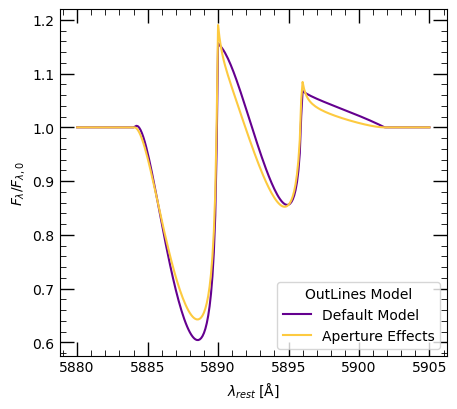

In [30]:
w = np.linspace(5880,5905,251)
plt.plot(w,modres.get_profile(w)+modabs.get_profile(w),label='Default Model')
plt.plot(w,modres_aper.get_profile(w)+modabs.get_profile(w),label='Aperture Effects')
plt.xlabel(r'$\lambda_{rest}\rm\:[\AA]$')
plt.ylabel(r'$F_\lambda/F_{\lambda,0}$')
plt.legend(title='OutLines Model')

Here is an example where the aperture of the spectrograph is updated iteratively

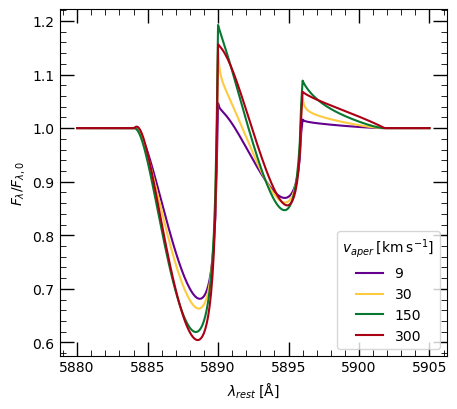

In [26]:
w = np.linspace(5880,5905,251)
vterm = modres_aper.params['TerminalVelocity']
for vap in [0.03,0.1,0.5,1.0]:
    modres_aper.update_params(['ApertureVelocity'],[vterm*vap])
    plt.plot(w,modres_aper.get_profile(w)+modabs.get_profile(w),label=int(round(vterm*vap*2.9978e5)))
plt.xlabel(r'$\lambda_{rest}\rm\:[\AA]$')
plt.ylabel(r'$F_\lambda/F_{\lambda,0}$')
plt.legend(title=r'$v_{aper}\rm\:[km\:s^{-1}]$')